# data preparation

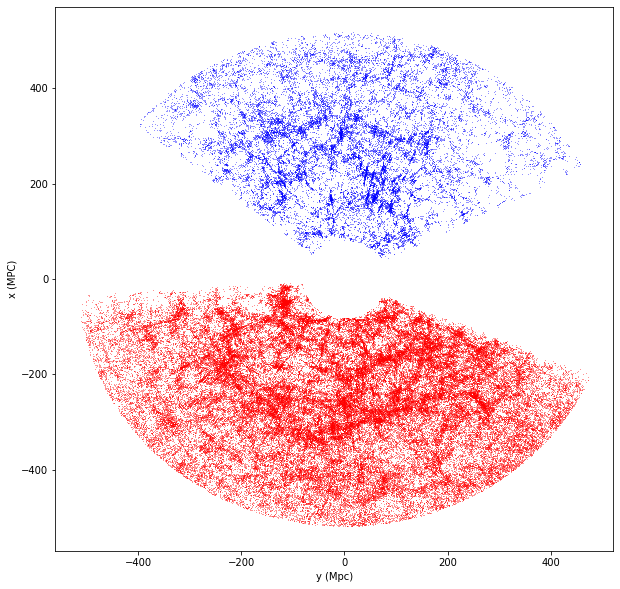

In [2]:
'''
data preparation
'''
import numpy as np
import matplotlib.pyplot as plt

# sdss specgal DataRelease 8
from astropy.io import fits
hdul = fits.open('SDSSspecgalsDR8_1.fit')
data = hdul[1].data

                                                        # Redshift cut
z = data['z']
data = data[(z > 0.0) & (z < 0.13)]
zgrid = np.linspace(min(data['z']), max(data['z']), 100)

                                                       # universe Model
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.274, Tcmb0=0)

                                                      # calculate the absolute magnitude
from scipy.interpolate import interp1d
mugrid = cosmo.distmod(zgrid).value
f = interp1d(zgrid, mugrid)
mu = f(data['z'])                                     # distance modulus:(apparent magnitude-absolute magnitude)
Mr = data['petroMag_r'] + data['extinction_r'] - mu   # M_abs = M_obs - distmod
data = data[(data['petroMag_r'] < 17.6) 
            & (data['petroMag_r'] >14.5)] 

                                                      # compute distances in the equatorial plane
                                                      # sample comoving distance
Dcgrid = cosmo.comoving_distance(zgrid).value
f = interp1d(zgrid, Dcgrid)
dist = f(data['z'])

                                                               # projection
locs = np.vstack([dist * np.cos(data['ra'] * np.pi / 180.),
                  dist * np.sin(data['ra'] * np.pi / 180.)]).T

                                                               # large structure of the universe
fig = plt.figure(figsize=(10,10))
blue = locs[locs[:,0]>0]
red = locs[locs[:,0]<0]
plt.scatter(red[:, 1], red[:, 0], s=0.3, lw=0, c='r')
plt.scatter(blue[:, 1], blue[:, 0], s=0.3, lw=0, c='b')
plt.xlabel('y (Mpc)')
plt.ylabel('x (MPC)')
#plt.savefig('large_scale_structure.png',format='png',dpi=500)
plt.show()

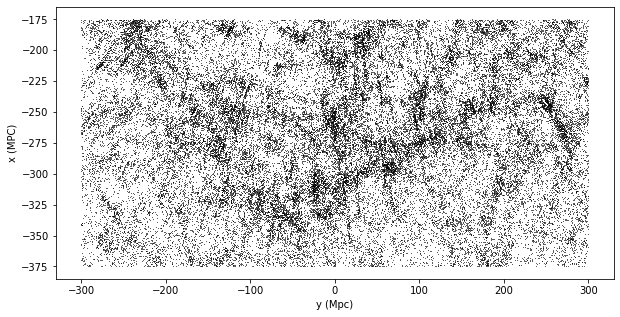

In [3]:
# cut to the part of the sky with the "great wall"
fig = plt.figure(figsize=(10,5))
great_wall = locs[ (abs(locs[:,1])<300) & (abs(locs[:,1])>-300)
                   & (locs[:,0]<-175) & (locs[:,0]>-375) ] 
plt.scatter(great_wall[:,1], great_wall[:,0], s=0.5, lw=0, c='k')
plt.xlabel('y (Mpc)')
plt.ylabel('x (MPC)')
#plt.savefig('the_great_wall.png',format='png',dpi=500)
plt.show()

# density estimation for the sdss great wall

 scale: 1.55098 Mpc


C:\Users\Littl\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


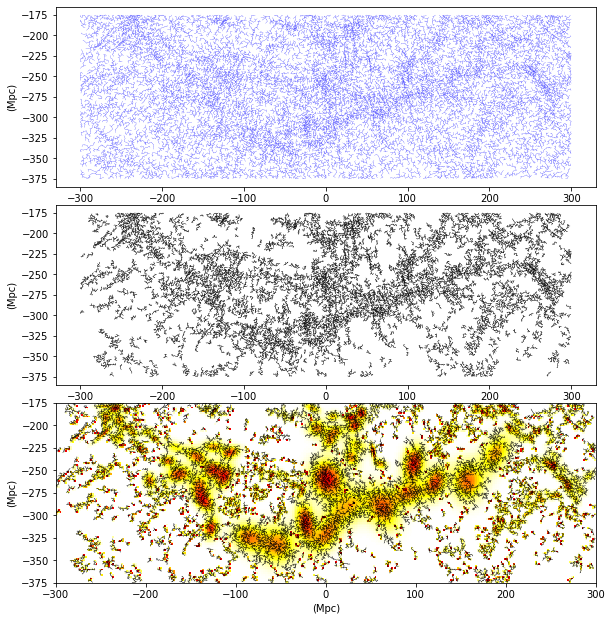

In [6]:
'''
Hierarchical Clustering
'''
from scipy import sparse
from astroML.clustering import HierarchicalClustering, get_graph_segments

                                                        # clustering
X = great_wall
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 300)

n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff, # edge_cut_off:表示 cluster过程中 f% 的 edge保留
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_                      # numbers of clusters found
labels = model.labels_                                  # clusters

                                                        # Get graph segments for plotting a 2D graph
T_x, T_y = get_graph_segments(model.X_train_,           # full_tree:连接 sample point 之间的有向线，表示 clustering
                              model.full_tree_)         # 的 tree 生成过程  

T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,        # cluster_graph_:the final (truncated) graph 
                                          model.cluster_graph_)  


                                                        # Gaussian density estimation for clusters
Nx = 100                                                # deisign the grid:exact division for coordinates   
Ny = 300                                                                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
from sklearn.neighbors.kde import KernelDensity as KD
for i in range(n_components):
    ind = (labels == i)                                  # training point in the cluster labels i .
    Npts = ind.sum()                                     # number of total points for label i 
    Nclusters = min(12, Npts // 5)                       # 一个 label set 里最多有 12个 Gaussian component
    gmm = GM(Nclusters, random_state=0).fit(great_wall[ind])     
    dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
    density += dens / dens.max()                         # relative density

density = density.reshape((Ny, Nx))

                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, left=0.15, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.plot(T_y, T_x, c='b', lw=0.2)

ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312,aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.4)
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313,aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.4)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
#plt.savefig('clustered_gw.png',format='png',dpi=500)
plt.show()

C:\Users\Littl\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(0, 0.5, '(Mpc)')

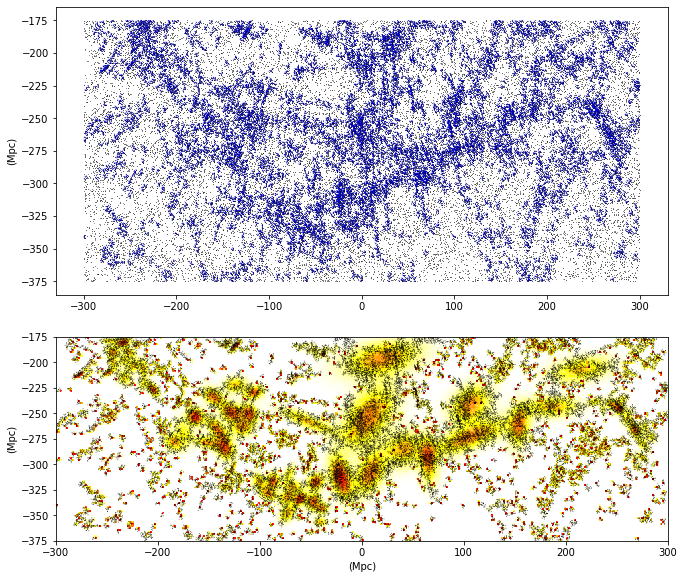

In [7]:
'''
dbscan for the great wall
'''
X = great_wall

from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2,min_samples=8)
model.fit(great_wall)
core = model.core_sample_indices_ 
comp = model.components_
label = model.labels_ 

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 300)

Nx = 100                                                # deisign the grid:exact division for coordinates   
Ny = 300                                                # otherwise: density->nan                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
from sklearn.neighbors.kde import KernelDensity as KD
n_components = max(label)
c = []
for i in range(n_components):
    ind = (label == i)                                  # training point in the cluster labels i .
    Npts = ind.sum()                                     # number of total points for label i 
   # if Npts >= 100:
    c.append(list(comp[i]))
    Nclusters = min(12, Npts//5+1)                       # 一个 label set 里最多有 12个 Gaussian component
    gmm = GM(Nclusters, random_state=0).fit(great_wall[ind])  
    dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
    density += dens / dens.max()                         # relative density
density = density.reshape((Ny, Nx))    
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='auto')

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])

ax.scatter(X[:,1],X[:,0],s=0.5,lw=0,color='k')
ax.scatter(X[:, 1], X[:, 0], s=0.5, lw=0,color=colors[label])
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='auto')
colors = np.array(list(islice(cycle(['k']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])
ax.scatter(X[:,1],X[:,0],s=0.6,lw=0,color=colors[label])
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
#plt.savefig('clustered-ds_gw.png',format='png',dpi=500)

In [21]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2,min_samples=8)
model.fit(great_wall)
core = model.core_sample_indices_ 
comp = model.components_
label = model.labels_ 

In [59]:
from sklearn.neighbors import NearestNeighbors

clf = NearestNeighbors(2).fit(np.array(c))
G = clf.kneighbors_graph().toarray()



In [ ]:

import math
from typing import List
 
def point_connect(pots):
    
    l = len(pots)
    
    con = [pots[0]]     # 已经连线的点集，先随便放一个点进去
    not_con = pots[1:]  # 还没连线的点集
    paths = []          # 所有连线
    length_total = 0    # 总连线长度
    for _ in range(l - 1):  # 共 l-1 条连线
        # 得到下一条连线的两点a、b 及其距离length_ab
        a, b = con[0], not_con[0]  # 先任意选两个点
        length_ab = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
        for m in con:
            for n in not_con:
                lg = math.sqrt((m[0] - n[0]) ** 2 + (m[1] - n[1]) ** 2)
                if lg < length_ab:  # 如果有更短的
                    length_ab = lg
                    a, b = m, n
 
        # 记录
        paths.append([pots.index(a), pots.index(b)])   # 记录连线ab
        con.append(b)      # 已连接点集中记录点b
        not_con.remove(b)  # 未连接点集中删除点b
        length_total += length_ab  # 记录总长度

    return paths, length_total

import matplotlib.pyplot as plt
import random
import math
from typing import List
 
 
 
def draw(pots: List[list], paths: List[list]):
    """把点和路径画出来"""
    plt.figure(figsize=(10, 10))
    c = np.array(c)
    plt.scatter(c[:,1],c[:,0])
    plt.scatter(X[:,1],X[:,0],s=0.6,lw=0,color=colors[label])
    plt.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax]) 
    
    for a, b in paths:
        x = [pots[a][0], pots[b][0]]
        y = [pots[a][1], pots[b][1]]
        plt.plot(y, x, marker='o')
    
    #plt.xticks(range(math.floor(l), math.ceil(h) + 1))
    #plt.yticks(range(math.floor(l), math.ceil(h) + 1))
    #plt.grid(linestyle='--')
    #plt.show()

paths, length_total = point_connect(c)  # 求得路径
draw(c,paths)

print(len(paths), length_total)


C:\Users\Littl\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


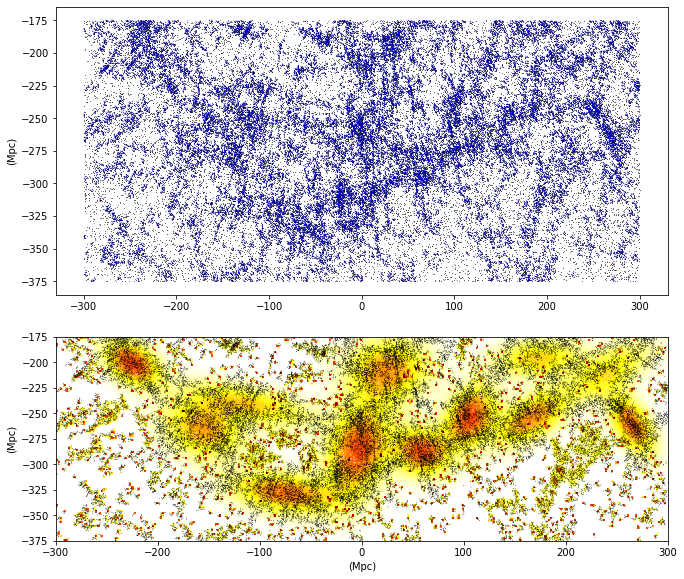

In [196]:
'''
optics for the great wall
'''
from sklearn.cluster import OPTICS
model = OPTICS(min_samples=6,max_eps=2,cluster_method='dbscan')
model.fit(great_wall)
label = model.labels_ 

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 300)

Nx = 100                                                # deisign the grid:exact division for coordinates   
Ny = 300                                                # otherwise: density->nan                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
n_components = max(label)
for i in range(n_components):
    ind = (label == i)                                  # training point in the cluster labels i .
    if len(great_wall[ind])>2:
        Npts = ind.sum()                                     # number of total points for label i 
        Nclusters = min(12, Npts//5+1)                       # 一个 label set 里最多有 12个 Gaussian component
        gmm = GM(Nclusters, random_state=0).fit(great_wall[ind])     
        dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
        density += dens / dens.max()                         # relative density
density = density.reshape((Ny, Nx))    
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='auto')

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])

ax.scatter(X[:,1],X[:,0],s=0.5,lw=0,color='k')
ax.scatter(X[:, 1], X[:, 0], s=0.5, lw=0,color=colors[label])
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='auto')
colors = np.array(list(islice(cycle(['k']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])
ax.scatter(X[:,1],X[:,0],s=0.6,lw=0,color=colors[label])
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
plt.savefig('clustered-op_gw.png',format='png',dpi=500)

In [ ]:
'''
SpectralClustering for the great_wall
'''
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=12)
model.fit(great_wall)
label = model.labels_

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 300)

Nx = 100                                                # deisign the grid:exact division for coordinates   
Ny = 300                                                # otherwise: density->nan                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
n_components = max(label)
for i in range(n_components):
    ind = (label == i)                                  # training point in the cluster labels i .
    Npts = ind.sum()                                     # number of total points for label i 
    Nclusters = min(12, Npts//5+1)                       # 一个 label set 里最多有 12个 Gaussian component
    gmm = GM(Nclusters, random_state=0).fit(great_wall[ind])     
    dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
    density += dens / dens.max()                         # relative density
density = density.reshape((Ny, Nx))    
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='auto')

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])

ax.scatter(X[:,1],X[:,0],s=0.5,lw=0,color='k')
ax.scatter(X[:, 1], X[:, 0], s=0.5, lw=0,color=colors[label])
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='auto')
colors = np.array(list(islice(cycle(['k']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])
ax.scatter(X[:,1],X[:,0],s=0.6,lw=0,color=colors[label])
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
plt.savefig('clustered-sp_gw.png',format='png',dpi=500)

# extend Density-Esitimation to the whole LLS

In [21]:
'''
extend HCA to the cosmic web
'''
from scipy import sparse
from astroML.clustering import HierarchicalClustering, get_graph_segments

                                                        # clustering
X = locs
xmin, xmax = (-500, 500)
ymin, ymax = (-500, 500)

n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff, # edge_cut_off:表示 cluster过程中 f% 的 edge保留
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_                      # numbers of clusters found
labels = model.labels_                                  # clusters

                                                        # Get graph segments for plotting a 2D graph
T_x, T_y = get_graph_segments(model.X_train_,           # full_tree:连接 sample point 之间的有向线，表示 clustering
                              model.full_tree_)         # 的 tree 生成过程  

T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,        # cluster_graph_:the final (truncated) graph 
                                          model.cluster_graph_)  


                                                        # Gaussian density estimation for clusters
Nx = 500                                                # deisign the grid:exact division for coordinates   
Ny = 500                                                                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
for i in range(n_components):
    ind = (labels == i)                                  # training point in the cluster labels i .
    Npts = ind.sum()                                     # number of total points for label i 
    Nclusters = min(12, Npts // 5)                       # 一个 label set 里最多有 12个 Gaussian component
    gmm = GM(Nclusters, random_state=0).fit(X[ind])     
    dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
    density += dens / dens.max()                         # relative density

density = density.reshape((Ny, Nx))

'''
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.15, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.3)

ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='b', lw=0.2)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

plt.savefig('clustered-cw.png',format='png',dpi=500)
plt.show()
'''

 scale: 1.933 Mpc


C:\Users\Littl\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


"\n                                                         # Plot the results\nfig = plt.figure(figsize=(10, 10))\nfig.subplots_adjust(hspace=0.15, left=0.1, right=0.95, bottom=0.1, top=0.9)\n\nax = fig.add_subplot(211, aspect='equal')\nax.plot(T_y, T_x, c='k', lw=0.3)\n\nax.set_ylabel('(Mpc)')\n\nax = fig.add_subplot(212,aspect='equal')\nax.plot(T_trunc_y, T_trunc_x, c='b', lw=0.2)\nax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,\n          extent=[ymin, ymax, xmin, xmax])\n\nax.set_xlim(ymin, ymax)\nax.set_ylim(xmin, xmax)\nax.set_xlabel('(Mpc)')\nax.set_ylabel('(Mpc)')\n\nplt.savefig('clustered-cw.png',format='png',dpi=500)\nplt.show()\n"

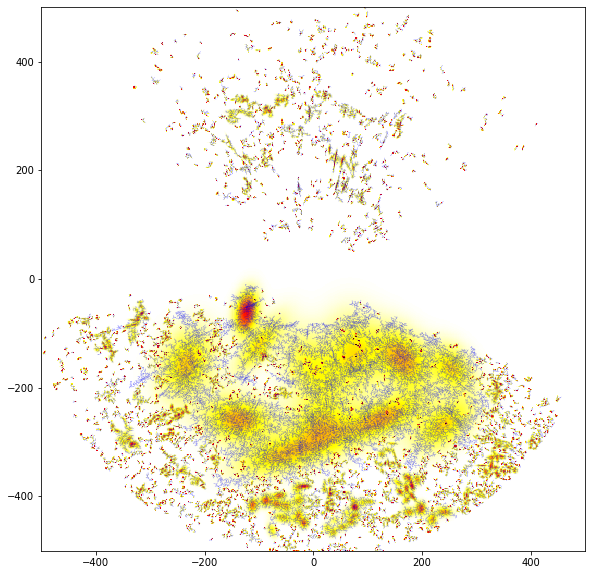

In [22]:
#ax = fig.add_subplot(313,aspect='equal')
plt.figure(figsize=(10,10))
plt.plot(T_trunc_y, T_trunc_x, c='b', lw=0.15,zorder=2)
plt.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax],zorder = 1)
plt.savefig('clustered_cosmic-web.png',format='png',dpi=500)

In [ ]:
'''
dbscan for the cosmic web
'''
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2,min_samples=8)
model.fit(locs)
core = model.core_sample_indices_ 
comp = model.components_
label = model.labels_ 

xmin, xmax = (-500, 500)
ymin, ymax = (-500, 500)

Nx = 500                                                # deisign the grid:exact division for coordinates   
Ny = 500                                                # otherwise: density->nan                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
n_components = max(label)
for i in range(n_components):
    ind = (label == i)                                  # training point in the cluster labels i .
    Npts = ind.sum()                                     # number of total points for label i 
    Nclusters = min(12, Npts//5+1)                       # 一个 label set 里最多有 12个 Gaussian component
    gmm = GM(Nclusters, random_state=0).fit(locs[ind])     
    dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
    density += dens / dens.max()                         # relative density
density = density.reshape((Ny, Nx))    
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='equal')

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])

ax.scatter(X[:,1],X[:,0],s=0.2,lw=0,color='k')
ax.scatter(X[:, 1], X[:, 0], s=0.3, lw=0,color=colors[label])
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='equal')
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])
ax.scatter(X[:,1],X[:,0],s=0.15,lw=0,color=colors[label])
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
plt.savefig('clustered-ds_cw.png',format='png',dpi=500)

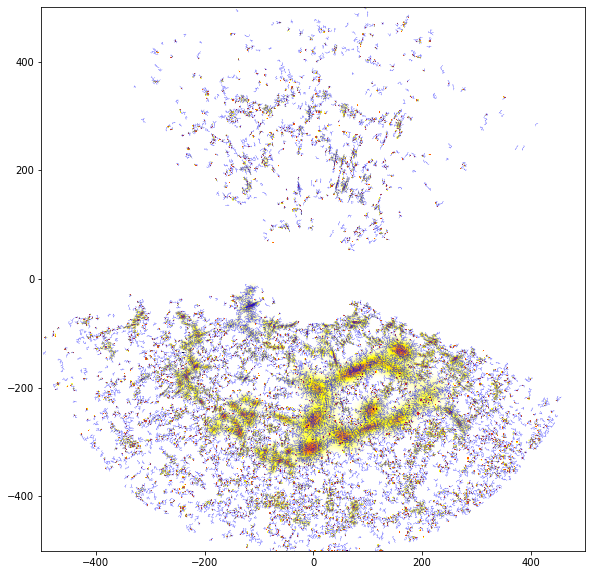

In [27]:
#ax = fig.add_subplot(313,aspect='equal')
plt.figure(figsize=(10,10))
plt.plot(T_trunc_y, T_trunc_x, c='b', lw=0.2,zorder=2)
plt.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax],zorder = 1)
plt.savefig('clustered-dbscan_cosmic-web.png',format='png',dpi=500)

In [ ]:
'''
MS for the great wall
'''
from sklearn.cluster import MeanShift
model = MeanShift()
model.fit(great_wall)
label = model.labels_ 

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 300)

Nx = 100                                                # deisign the grid:exact division for coordinates   
Ny = 300                                                # otherwise: density->nan                 
Xgrid = np.vstack(map(np.ravel,                         # map(funtion,iterable):function操作遍历 iterable 数据集   
                      np.meshgrid(np.linspace(xmin, xmax, Nx),
                                np.linspace(ymin, ymax, Ny)))).T  

density = np.zeros(Xgrid.shape[0])                      # restore density for each sample

from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.mixture import GaussianMixture as GM
n_components = max(label)
for i in range(n_components):
    ind = (label == i)                                  # training point in the cluster labels i .
    if len(great_wall[ind])>2:
        Npts = ind.sum()                                     # number of total points for label i 
        Nclusters = min(12, Npts//5+1)                       # 一个 label set 里最多有 12个 Gaussian component
        gmm = GM(Nclusters, random_state=0).fit(great_wall[ind])     
        dens = np.exp(gmm.score_samples(Xgrid))              # weighted log probabilities for grids
        density += dens / dens.max()                         # relative density
density = density.reshape((Ny, Nx))    
                                                         # Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='auto')

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['b']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])

ax.scatter(X[:,1],X[:,0],s=0.5,lw=0,color='k')
ax.scatter(X[:, 1], X[:, 0], s=0.5, lw=0,color=colors[label])
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(212,aspect='auto')
colors = np.array(list(islice(cycle(['k']),
                                      int(max(label) + 1))))
colors = np.append(colors, ["white"])
ax.scatter(X[:,1],X[:,0],s=0.6,lw=0,color=colors[label])
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,  # hot_r -> reverse'hot' 
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')
#plt.savefig('clustered-op_gw.png',format='png',dpi=500)
plt.show()